# Location vs. AB?

## Import Packages

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

main_raw = pd.read_csv("/content/drive/MyDrive/datathink/Main_BusinessDataBBB_02022024.csv")
out = pd.read_csv('/content/drive/MyDrive/datathink/OutOfBusiness.csv')

Mounted at /content/drive


In [ ]:
# Load Map Data
counties_gdf = gpd.read_file('/content/drive/MyDrive/datathink/ext_data/tl_2023_us_county/tl_2023_us_county.shp')

## Data cleaning: Get Rid of Out of Business & all repetitive business

In [ ]:
out_of_business_ids = out['Business ID'].unique()
filtered_main = main_raw[~main_raw['Business ID'].isin(out_of_business_ids)]
deduplicated_main = filtered_main.drop_duplicates(subset='Business ID', keep='first')
main = deduplicated_main

# Accredited Business Count by Location (AB?== True)

In [ ]:
# Filter the dataset for BBB accredited businesses
accredited_businesses = main[main['AB?'] == True]

# Aggregate the data by 'County' to count the number of accredited businesses in each county
county_accreditation_counts = accredited_businesses.groupby('County').size().reset_index(name='Accredited Businesses Count')

# Sort the data for better readability
county_accreditation_counts_sorted = county_accreditation_counts.sort_values(by='Accredited Businesses Count', ascending=False)

# Display the aggregated data
county_accreditation_counts_sorted.head()

,County,Accredited Businesses Count
18,FULTON,1376
21,GWINNETT,1175
8,COBB,1081
11,DEKALB,663
5,CHEROKEE,311


In [ ]:
# Filter for Georgia counties only using Georgia's FIPS code "13"
georgia_counties = counties_gdf[counties_gdf['STATEFP'] == '13']

# Standardize county names in both DataFrames to have initial upper and rest lower
georgia_counties['NAME'] = georgia_counties['NAME'].str.title();
county_accreditation_counts_sorted['County'] = county_accreditation_counts_sorted['County'].str.title();

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Count of Business that are not accredited by location

In [ ]:
# Filter the dataset for BBB not accredited businesses
no_accredited_businesses = main[main['AB?'] == False]

# Aggregate the data by 'County' to count the number of not accredited businesses in each county
no_county_accreditation_counts = no_accredited_businesses.groupby('County').size().reset_index(name='No Accredited Businesses Count')

# Sort the data for better readability
no_county_accreditation_counts_sorted = no_county_accreditation_counts.sort_values(by='No Accredited Businesses Count', ascending=False)

# Display the aggregated data
no_county_accreditation_counts_sorted.head()

,County,No Accredited Businesses Count
167,FULTON,29383
189,GWINNETT,19812
99,COBB,17730
130,DEKALB,15760
96,CLAYTON,4750


In [ ]:
# Filter for Georgia counties only using Georgia's FIPS code "13"
georgia_counties = counties_gdf[counties_gdf['STATEFP'] == '13']

# Standardize county names in both DataFrames to have initial upper and rest lower
georgia_counties['NAME'] = georgia_counties['NAME'].str.title();                                                # Adjust for the shapefile DataFrame
no_county_accreditation_counts_sorted['County'] = no_county_accreditation_counts_sorted['County'].str.title();  # Adjust for your data

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Proportion of the business accepted in each County


In [ ]:
#Proportion of the business accepted in each County
merged_data = pd.merge(county_accreditation_counts_sorted, no_county_accreditation_counts_sorted, on='County', how='outer')
merged_data = merged_data.fillna(0)

merged_data['Accredited_Proportion'] = merged_data['Accredited Businesses Count'] / (merged_data['Accredited Businesses Count'] + merged_data['No Accredited Businesses Count'])
merged_data

,County,Accredited Businesses Count,No Accredited Businesses Count,Accredited_Proportion
0,Fulton,1376.0,29383,0.044735
1,Gwinnett,1175.0,19812,0.055987
2,Cobb,1081.0,17730,0.057466
3,Dekalb,663.0,15760,0.040370
4,Cherokee,311.0,4582,0.063560
...,...,...,...,...
489,Brown,0.0,1,0.000000
490,Randall,0.0,1,0.000000
491,Kanawha,0.0,1,0.000000
492,Johnston,0.0,1,0.000000


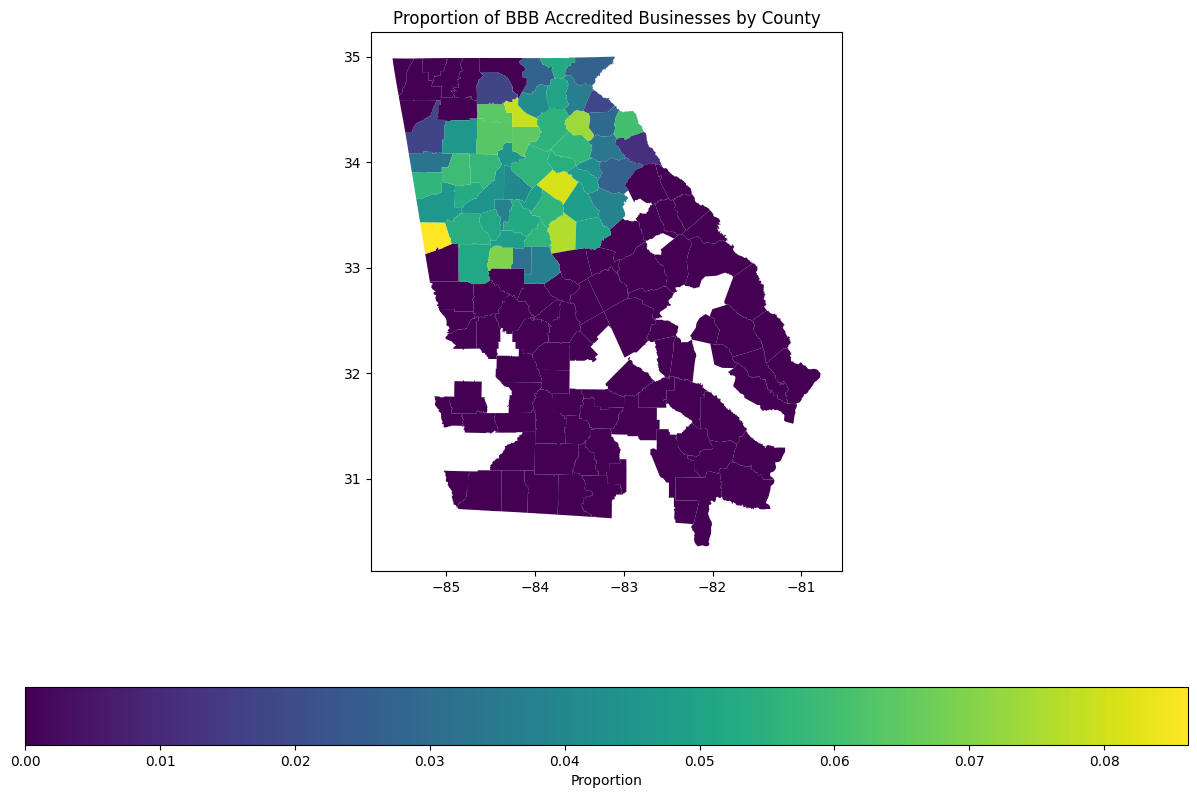

In [ ]:
#map data!
map_data3 = georgia_counties.merge(merged_data, left_on='NAME', right_on='County')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
map_data3.plot(column='Accredited_Proportion', ax=ax, legend=True,
                  legend_kwds={'label': "Proportion",
                               'orientation': "horizontal"})
plt.title("Proportion of BBB Accredited Businesses by County")
plt.show()

#RUNNING Statistical test

In [ ]:
# Convert 'AB?' from boolean to int (0 for False, 1 for True)
main['AB?'] = main['AB?'].astype(int)

# Generate dummy variables for 'County'
county_dummies = pd.get_dummies(main['County'], drop_first=True)
X = county_dummies  # Independent variables
y = main['AB?']  # Dependent variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs')
logistic_model.fit(X_train, y_train)

# Predicting the test set results and calculating the classification report
predictions = logistic_model.predict(X_test)
report = classification_report(y_test, predictions)

report;

<ipython-input-11-0e009dac9d36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['AB?'] = main['AB?'].astype(int)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/li

#Chi-Squared Test

In [ ]:
# Group data by "County" and calculate the count of True and False values in the "AB?" variable
def group_and_count(df):
  return df.groupby('County')['AB?'].value_counts().unstack(fill_value=0)

result = group_and_count(main.copy())

#Run Chi-square test
chi2, p, _, _ = chi2_contingency(result)
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")

if p < 0.05:
    print("There is a significant association between County and enrollment status.")
else:
    print("There is no significant association between County and enrollment status.")

Chi-square value: 382.66676404228315
P-value: 0.9999261305923776
There is no significant association between County and enrollment status.


Finding:

--> Looking at the first map visualization, Atlanta Area especially fulton County area has the highest density of accredited businesses. However, the second map visualization which are comapnies that are not accredited also was populated mostly in the Atlanta Area. One explaination could be that there are simple much more businesses around metro area since it's big city. After running the Chi-square test, the p-value came out very high which indicates that there are actually no correlation between location and acrreditability.